In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42)

In [ ]:
# install transformer package
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 18.2 MB/s 
     |████████████████████████████████| 7.6 MB 38.1 MB/s 
     |████████████████████████████████| 182 kB 17.6 MB/s 


In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-63d5cf6f-b87e-a8af-9098-79fd4bdb8dcf)


In [ ]:
df = pd.read_csv('https://www.dropbox.com/s/bftxg089s8bx86f/Financial%20Sentiment%20Data.csv?dl=1')

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df['Sentence'], df['Sentiment'], test_size=0.25, random_state=42, stratify=df['Sentiment'])

In [ ]:
n_neu = train_y.value_counts()['neutral']
n_pos = train_y.value_counts()['positive']
n_neg = train_y.value_counts()['negative']

In [ ]:
# balance data -> upsample minority class
train = pd.concat([train_X, train_y], axis=1)
train_pos = pd.concat([train[train.Sentiment=='positive'], 
                      train[train.Sentiment=='positive'].sample(n=(n_neu-n_pos), replace=True, random_state=42)])
train_neg = pd.concat([train[train.Sentiment=='negative'],
                       train[train.Sentiment=='negative'].sample(n=(n_neu-n_neg), replace=True, random_state=42)])
train_balanced = pd.concat([train_pos, train_neg, train[train.Sentiment=='neutral']])
train_X, train_y = train_balanced['Sentence'], train_balanced['Sentiment']

In [ ]:
train_y.value_counts()

positive    2347
negative    2347
neutral     2347
Name: Sentiment, dtype: int64

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_query_length = 100

In [ ]:
# tokenize both the training set and the test set
source_train = tokenizer(train_X.values.tolist(), max_length=max_query_length, return_tensors='tf', truncation=True, padding='max_length')
source_test = tokenizer(test_X.values.tolist(), max_length=max_query_length, return_tensors='tf', truncation=True, padding='max_length')

In [ ]:
# tokenize labels
text_vectorization_label = keras.layers.TextVectorization()
text_vectorization_label.adapt(train_y.astype(str))
num_labels = text_vectorization_label.vocabulary_size()

label_train = text_vectorization_label(train_y.astype(str))
label_test = text_vectorization_label(test_y.astype(str))

In [ ]:
input_ids = keras.layers.Input(shape=(max_query_length,), name='input_ids', dtype='int32')
token_type_ids = keras.layers.Input(shape=(max_query_length,), name='token_type_ids', dtype='int32')
attention_mask = keras.layers.Input(shape=(max_query_length,), name='attention_mask', dtype='int32') 

embedding_layer = bert.bert(input_ids, token_type_ids, attention_mask)

CLS = embedding_layer.pooler_output

# Classifier
# x = keras.layers.Dense(256, activation='relu')(CLS)
# x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(units=256, activation='relu')(CLS)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=128, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=128, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_labels, activation="softmax")(x)

model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=outputs)

for layer in model.layers[:-4]:
  layer.trainable = False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'token_type_ids[0][0]',   

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),  
#  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
#  metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]) 

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00005)

In [ ]:
BATCH_SIZE = 64
epochs = 100

# Fit
history = model.fit([source_train['input_ids'], source_train['token_type_ids'], source_train['attention_mask']], label_train,
                    batch_size=BATCH_SIZE,
                    validation_data=([source_test['input_ids'], source_test['token_type_ids'], source_test['attention_mask']], label_test),
                    epochs=epochs)

Epoch 1/100
111/111 [==============================] - 75s 564ms/step - loss: 1.1337 - sparse_categorical_accuracy: 0.4274 - val_loss: 1.0016 - val_sparse_categorical_accuracy: 0.5558
Epoch 2/100
111/111 [==============================] - 59s 530ms/step - loss: 1.0377 - sparse_categorical_accuracy: 0.4563 - val_loss: 1.0226 - val_sparse_categorical_accuracy: 0.4853
Epoch 3/100
111/111 [==============================] - 58s 526ms/step - loss: 1.0146 - sparse_categorical_accuracy: 0.4755 - val_loss: 0.9996 - val_sparse_categorical_accuracy: 0.4921
Epoch 4/100
111/111 [==============================] - 59s 528ms/step - loss: 1.0032 - sparse_categorical_accuracy: 0.4830 - val_loss: 0.9428 - val_sparse_categorical_accuracy: 0.5476
Epoch 5/100
111/111 [==============================] - 59s 529ms/step - loss: 0.9803 - sparse_categorical_accuracy: 0.4984 - val_loss: 0.9892 - val_sparse_categorical_accuracy: 0.4921
Epoch 6/100
111/111 [==============================] - 59s 529ms/step - loss: 0.

46/46 [==============================] - 14s 221ms/step


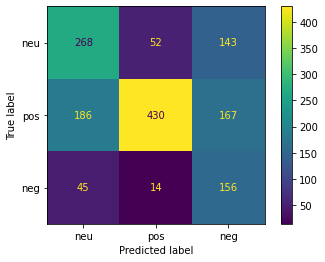

In [ ]:
pred = np.argmax(model.predict(x=[source_test['input_ids'], source_test['token_type_ids'], source_test['attention_mask']]),axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix(tf.squeeze(label_test), pred, labels=[2,3,4]),
                       display_labels=['neu','pos','neg'])
disp.plot()
plt.show()

In [ ]:
f1_score(tf.squeeze(label_test), pred, average='weighted')

0.6043549223086087

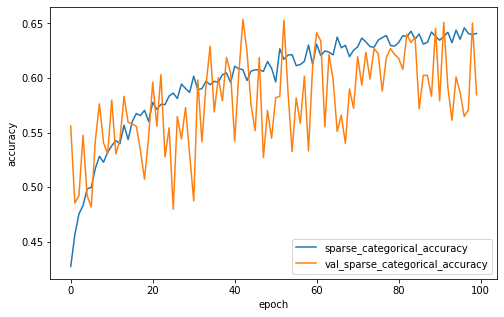

In [ ]:
# pd.DataFrame(history.history).plot(figsize=(8,5))
pd.DataFrame(history.history)[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(figsize=(8,5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

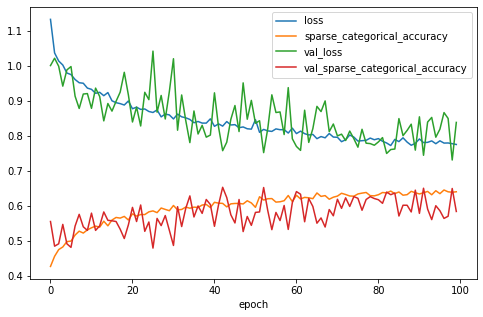

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
# pd.DataFrame(history.history)[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(figsize=(8,5))
plt.xlabel('epoch')
plt.show()